In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Flavor composition analysis

They key challenge in measuring the flavor composition of astrophysical neutrinos is distinguishing single cascades (produced by $\nu_e$ CC and $\nu$ NC intercations) from double cascades produced by tau neutrinos. 

We run two dedicated reconstruction algorithm:
- Monopod for single cascades
- Taupede for double cascades
You can read more about them here: https://link.springer.com/article/10.1140/epjc/s10052-022-10795-y

Certain single cascade events are reconstructed with long tau lengths, contaminating the double cascade sample with tau neutrinos. 

In this notebook we have a hdf5 file that summarized 4000 files with simulated electron neutrino interactions. All these events are reconstructed with both reconstruction algorithms. I am very curious if we can find out which class of events are reconstructed with long lengths and why. The next step would be to improve our algorithms and do an enhanced flavor composition measurement.

We have the following files that contain
/data/user/tvaneede/GlobalFit/reco_processing/hdf/output/v2_allvar/NuE_22612.h5
* 2000 files
* Simulated neutrino energy: $6 < \log_{10} E_\nu < 8$

/data/user/tvaneede/GlobalFit/reco_processing/hdf/output/v2_allvar/NuE_22613.h5
* 1997 files
* Simulated neutrino energy: $4 < \log_{10} E_\nu < 6$

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tables


In [5]:
file_path_22612 = "/data/user/tvaneede/GlobalFit/reco_processing/hdf/output/v2_allvar/NuE_22613.h5"
hdf_22612 = pd.HDFStore(file_path_22612,'r')

The events are simulated according to a certain neutrino spectrum. If you want to properly weight them, you should use the simweights package. Read more about it here:
https://docs.icecube.aq/simweights/main/getting_started.html

In [7]:
import simweights

I use the astrophysical HESE flux found by Neha to weight the events. I can send you her thesis later.

In [13]:
# astro
gamma_astro = 2.87
per_flavor_norm = 2.12
livetime_s = 12*365*24*60*60 # 12 yr
def AstroFluxModel(pdgid, energy, cos_zen):
    flux = 0.5*(per_flavor_norm*1e-18)*(energy/1e5)**-gamma_astro
    return flux

In [14]:
weighter_22612 = simweights.NuGenWeighter( hdf_22612,nfiles=2000)
weights_22612 = weighter_22612.get_weights(AstroFluxModel) * livetime_s 

Now we can make plots and investigate! For example, the true neutrino energy

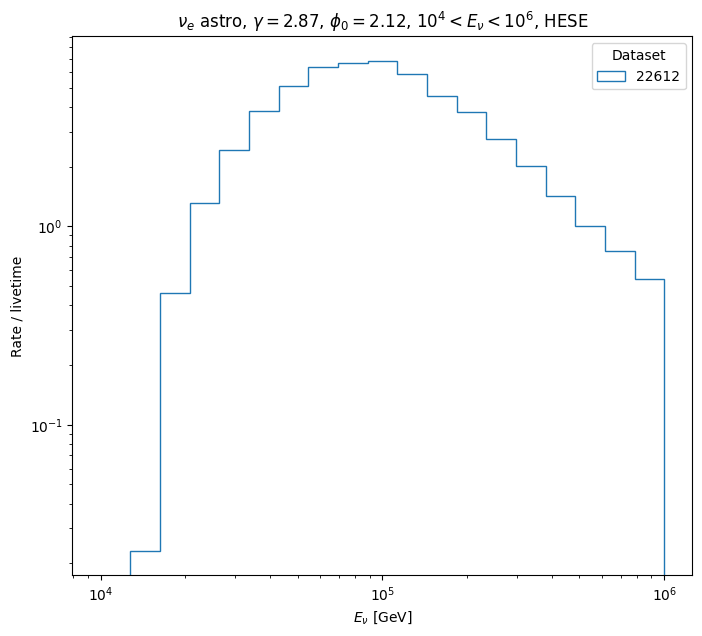

In [21]:
energy_nu = weighter_22612.get_column("I3MCWeightDict", "PrimaryNeutrinoEnergy")

bins = np.geomspace(1e4, 1e6, 20)

fig, ax = plt.subplots(1, 1,figsize =(8,7))

hist, _ = np.histogram(energy_nu, bins=bins, weights=weights_22612)

ax.hist(energy_nu, weights=weights_22612, 
        bins=bins, histtype="step", label="22612", color="C0")

ax.set_title(r"$\nu_e$ astro, $\gamma = 2.87$, $\phi_0=2.12$, $10^4 < E_\nu < 10^6$, HESE")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("Rate / livetime")
ax.set_xlabel(r"$E_\nu$ [GeV]")
ax.legend(title="Dataset")


The taupede reconstruction is stored under key `TaupedeFit_iMIGRAD_PPB0`, and Monopod with `MonopodFit_iMIGRAD_PPB0`. If you want to see which other keys are available you can run
```python
import tables

tf = tables.open_file(file_path_22612)

for node in tf.walk_nodes("/", classname=None):
    print(node)
```